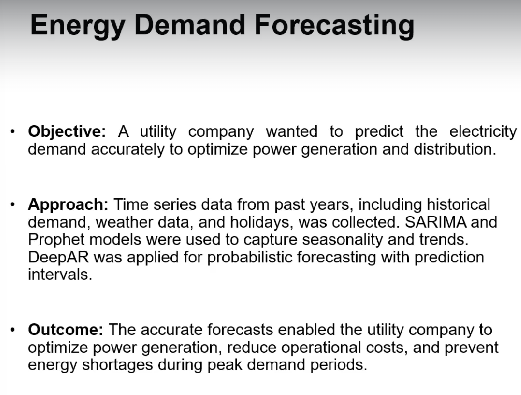

#### Time Series Analysis and Forecasting with ARIMA

##### Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('./TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   utc_timestamp        8784 non-null   object 
 1   IT_load_new          8712 non-null   float64
 2   IT_solar_generation  8784 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


##### Visualise the data

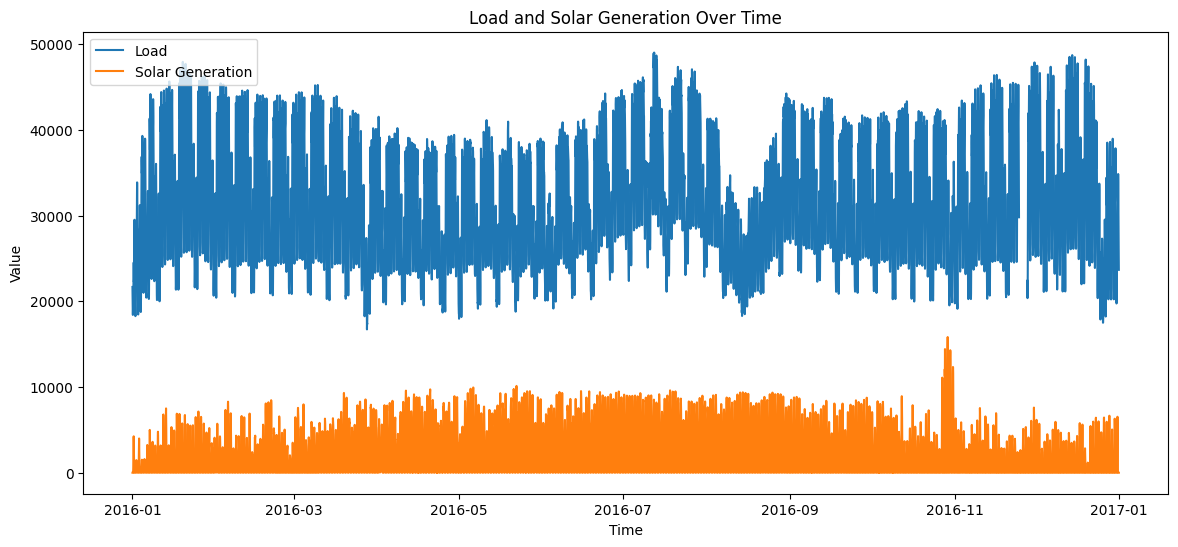

In [ ]:

# Convert utc_timestamp to datetime
data['utc_timestamp']= pd.to_datetime(data['utc_timestamp'])

# Plot the data

plt.figure(figsize=(14,6))

plt.plot(data['utc_timestamp'],data['IT_load_new'],label='Load')
# plt.plot(data['utc_timestamp'],data['IT_solar_generation'],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation Over Time')
plt.show()

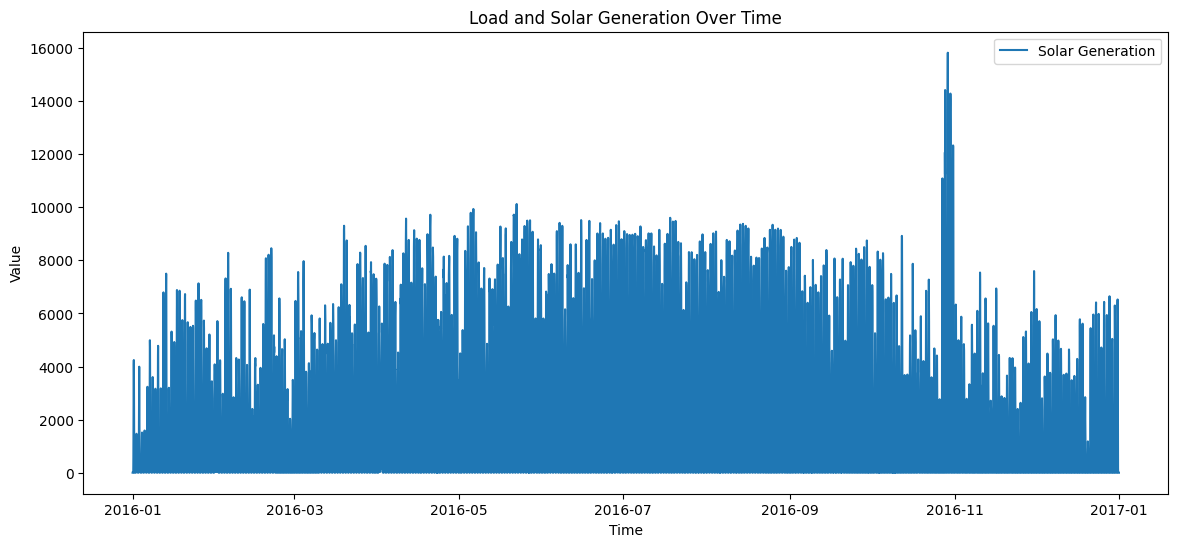

In [4]:
plt.figure(figsize=(14,6))


plt.plot(data['utc_timestamp'],data['IT_solar_generation'],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation Over Time')
plt.show()

The plot shows both the load and solar generation over time for the year 2016. The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it's important to check for stationarity in your time series data. Stationarity is a property of time series data that implies the mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require the data to be stationary.

Let's perform an Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

##### Handle Missing Values

In [5]:
# Check for missing values
data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [7]:

# fill missing values with forward filling
data['IT_load_new'].fillna(method='ffill', inplace=True)

# Check for missing values again
print("Missing values after filling:")
print(data.isnull().sum())


Missing values after filling:
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_23968\3436243671.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method='ffill', inplace=True)


##### Check For Stationarity